In [1]:
#!pip install tensorflow

In [2]:
import tensorflow as tf

2023-03-16 09:29:22.417096: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [4]:
import matplotlib.pyplot as plt
import numpy as np

from copy import deepcopy
from statistics import stdev
from time import time

<hr>

# My Custom Graphing Setup

In [5]:
def progress_graph(graph_history, start_at=0):
    # data for graphs
    # ----------------
    loss = graph_history["loss"][start_at:]
    mse = graph_history["mse"][start_at:]
    binary_accuracy = graph_history["binary_accuracy"][start_at:]
    
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

    # Binary Cross Entropy
    # ---------------------
    axes[0].plot(range(len(loss)), loss, label="loss")
    axes[0].set_xlabel('step') # Set the y axis label of the current axis.
    axes[0].set_ylabel('loss') # Set a title of the current axes.
    axes[0].set_title('loss over training steps') 
    axes[0].legend() # show a legend on the plot

    
    # Mean Squared Error
    # -------------------
    axes[1].plot(range(len(mse)), mse, label="mse")
    axes[1].set_xlabel('step') # Set the y axis label of the current axis.
    axes[1].set_ylabel('mse') # Set a title of the current axes.
    axes[1].set_title('mse over training steps') 
    axes[1].legend() # show a legend on the plot
    
    
    # Binary Accuracy
    # ----------------
    axes[2].plot(range(len(binary_accuracy)), binary_accuracy, label="accuracies")
    axes[2].set_xlabel('step') # Set the y axis label of the current axis.
    axes[2].set_ylabel('accuracy') # Set a title of the current axes.
    axes[2].set_title('accuracy over training steps') 
    axes[2].legend() # show a legend on the plot

    
    return fig.tight_layout()

In [6]:
def time_display(seconds):
    output = ""

    if seconds > 60:
        minutes = int(seconds // 60)
        seconds = seconds  % 60

        if minutes > 60:
            hours   = minutes // 60
            minutes = minutes  % 60
            output = "{:>2}h {:>2}m {:>2}s".format(hours, minutes, round(seconds, 1))

        else:
            output = "{:>2}m {:>2}s".format(minutes, round(seconds, 1))

    else:
        output = "{:>2}s".format(round(seconds, 1))

    return output

In [7]:
def check_last_x(losses, x=10, threshold=0.1):
    #best_loss = 100
    #threshold = 0.10
    last_x_rule = x
    last_x = 0
    
    best_loss = losses[0]
    for i in range(1, len(losses)):
        
        epoch_loss = losses[i]
        if epoch_loss < best_loss:
            improvement = (best_loss-epoch_loss)/best_loss
            if (improvement) > threshold:
                best_loss = epoch_loss
                last_x = 0
            else:
                last_x += 1
                
        else: 
            last_x += 1

        if last_x >= last_x_rule:
            # break training loop and print results
            print("FAILED at {} steps with loss: {}".format(i, best_loss))
            return False
            
    print("STILL GOING at {} steps with loss: {}".format(i, best_loss))
    return True

<hr>

# import training data

In [8]:
import pandas as pd #1
import os           #3

In [9]:
given_data_folder = '../data_prep/prepped'

file_names = os.listdir(given_data_folder)
file_names.sort()
file_names

['.DS_Store',
 'M_predictions.csv',
 'M_testing.csv',
 'M_testing_embedding.csv',
 'M_testing_embedding_2023.csv',
 'M_training_data.csv',
 'M_training_data_embedding.csv',
 'M_training_data_embedding_2023.csv',
 'W_predictions.csv',
 'W_testing.csv',
 'W_testing_embedding.csv',
 'W_testing_embedding_2023.csv',
 'W_training_data.csv',
 'W_training_data_embedding.csv',
 'W_training_data_embedding_2023.csv',
 'predictions']

In [10]:
training_data_file = 'M_training_data_embedding.csv'

In [11]:
file_path = given_data_folder + '/' + training_data_file 
training_df  = pd.read_csv(file_path)
print(len(training_df))

training_df.head(5)

25156


,team1_id,team2_id,Pts,FG%2,FGA2,FG%3,FGA3,FT%,FTA,OR,...,xFTA_a,xOR_a,xDR_a,xAst_a,xTO_a,xStl_a,xBlk_a,xPF_a,xrecW%,solution
0,11332021.0,13242021.0,0.590426,0.592805,0.85,0.554705,0.560606,0.586207,0.250000,0.866667,...,-0.43750,0.733333,0.090909,-0.714286,-0.00,-0.916667,-2.220446e-16,-0.0,-0.0,1
1,13242021.0,11332021.0,0.542553,0.533241,0.66,0.282976,0.818182,0.748863,0.640625,0.800000,...,0.28125,0.133333,0.060606,0.571429,0.75,0.333333,-2.857143e-01,-0.0,-0.5,-1
2,12282021.0,13252021.0,1.164894,0.943766,0.86,0.848012,0.742424,0.754310,0.750000,1.100000,...,-0.21875,-0.200000,0.090909,0.476190,-0.15,0.250000,7.142857e-01,-0.0,-1.0,-1
3,13252021.0,12282021.0,0.893617,0.885057,0.59,0.726891,0.803030,0.633677,0.843750,0.700000,...,0.09375,-0.266667,-0.121212,0.095238,0.10,-0.333333,4.285714e-01,-0.0,-1.0,-1
4,12992021.0,11522021.0,0.702128,0.578101,0.83,0.563809,0.666667,0.719212,0.562500,0.400000,...,-0.03125,0.666667,0.303030,0.333333,0.20,0.416667,-5.714286e-01,-0.0,-0.0,1


## get as rows

In [12]:
training_column_names = training_df.columns.tolist()

# get all data as columns
training_columns = []
for i in range(len(training_column_names)):
    new_column = list(training_df[training_column_names[i]])
    training_columns.append(new_column)
    
    
# get as rows
training_input_rows    = []
training_solution_rows = []
embedding_key_rows     = []
for i in range(len(training_columns[0])):
    new_input_row         = []
    new_solution_row      = [training_columns[-1][i]]
    new_embedding_key_row = [int(training_columns[0][i]), int(training_columns[1][i])]
    for j in range(2, len(training_columns)-1):
        new_input_row.append(training_columns[j][i])
        
    training_input_rows   .append(new_input_row)
    training_solution_rows.append(new_solution_row)
    embedding_key_rows    .append(new_embedding_key_row)
    
print(len(training_input_rows), len(training_input_rows[0]))
print(len(training_solution_rows), len(training_solution_rows[0]))
print(len(embedding_key_rows), len(embedding_key_rows[0]))

25156 82
25156 1
25156 2


In [13]:
#split = 7_000
#np_inputs    = np.array(training_input_rows[:split])
#np_solutions = np.array(training_solution_rows[:split])

#embedding_key_rows = embedding_key_rows[:split]

np_inputs    = np.array(training_input_rows)
np_solutions = np.array(training_solution_rows)

np_data = [np_inputs, np_solutions]

In [14]:
#np_inputs_2023    = np.array(training_input_rows)
#np_solutions_2023 = np.array(training_solution_rows)
#np_solutions_2023 = np.divide(np.add(np_solutions_2023, 1), 2)

<hr>

# Create and Train Model

In [15]:
np_solutions = np.divide(np.add(np_solutions, 1), 2)

In [16]:
print(np_inputs.shape)
print(np_solutions.shape)

(25156, 82)
(25156, 1)


In [17]:
input_neurons = int(np_inputs.shape[1])
neurons_ratio = (7/2)
neurons_per_layer = int(input_neurons * neurons_ratio)

print(neurons_per_layer)

287


### Model Configuration and Creation (activation functions, layer sizes, # of layers)

In [18]:
inner_activations = 'tanh'
inner_size = neurons_per_layer

In [19]:
# define the keras model
model = Sequential()
model.add(Dense(inner_size, input_shape=(input_neurons,), activation=inner_activations))
model.add(Dense(inner_size, activation=inner_activations)) # 1
model.add(Dense(inner_size, activation=inner_activations)) # 2

model.add(Dense(1, activation='sigmoid'))

2023-03-16 09:29:30.961709: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
              #optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              #loss='mse',
              metrics=[tf.keras.metrics.BinaryAccuracy(), 'mse'])

### Training the Model

In [21]:
graph_history = {"loss": [], "mse": [], "binary_accuracy": []}

In [22]:
# This builds the model for the first time:
start_time = time()

start = True
while start:
    
    history = model.fit(np_inputs, np_solutions, validation_split=0.20, 
              epochs=100, 
              batch_size=100,
              verbose=0)
    
    graph_history["loss"] += history.history['val_loss']
    graph_history["mse"] += history.history['val_mse']
    graph_history["binary_accuracy"] += history.history['val_binary_accuracy']

    print(time_display(time()-start_time))
    start = check_last_x(history.history['val_loss'], x=50, threshold=0.001)


end_time = (time()-start_time)


print()
print("TRAINING FINISHED - {}".format(time_display(end_time)))
print("-----------------")
print("LOSS:    ", history.history['val_loss'][-5:])
print("MSE:     ", history.history['val_mse'][-5:])
print("ACCURACY:", history.history['val_binary_accuracy'][-5:])

 2m 23.2s
STILL GOING at 99 steps with loss: 0.6425926089286804
 3m 46.9s
STILL GOING at 99 steps with loss: 0.6273869872093201
 5m 8.8s
STILL GOING at 99 steps with loss: 0.6193976402282715
 6m 29.9s
STILL GOING at 99 steps with loss: 0.6151420474052429
 7m 45.7s
FAILED at 84 steps with loss: 0.6138687133789062

TRAINING FINISHED -  7m 45.7s
-----------------
LOSS:     [0.6137075424194336, 0.6147704720497131, 0.614471971988678, 0.6158263087272644, 0.6154130697250366]
MSE:      [0.21274185180664062, 0.21320626139640808, 0.2130753993988037, 0.21367160975933075, 0.21349123120307922]
ACCURACY: [0.6641494631767273, 0.6633545160293579, 0.6641494631767273, 0.662162184715271, 0.662162184715271]


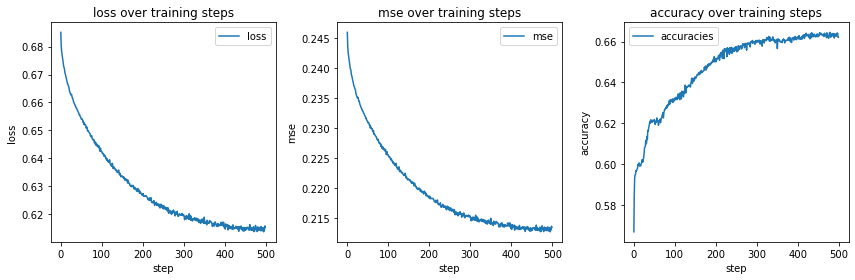

In [23]:
progress_graph(graph_history, start_at=0)

<br><br><br><br><br><br><br><br><br><br><br><br>


<hr>

# Creating Predictions

### import and process final prediction input data

In [26]:
testing_data_file = 'M_testing_embedding_2023.csv'

In [27]:
file_path = given_data_folder + '/' + testing_data_file 
testing_df  = pd.read_csv(file_path)
print(len(testing_df))

testing_df.head(5)

131406


,team1_id,team2_id,Pts,FG%2,FGA2,FG%3,FGA3,FT%,FTA,OR,...,xFGA3_a,xFTA_a,xOR_a,xDR_a,xAst_a,xTO_a,xStl_a,xBlk_a,xPF_a,xrecW%
0,1101_2023,1102_2023,0.805319,0.716581,0.842,0.608050,0.542424,0.758318,0.631250,0.513333,...,0.224242,-0.975000,-0.813333,-0.187879,0.047619,-0.835,0.308333,-0.228571,-0.842857,-0.2
1,1102_2023,1101_2023,0.680851,0.837502,0.540,0.647953,0.669697,0.716463,0.421875,0.273333,...,-0.375758,1.006250,0.793333,-0.366667,-0.661905,0.325,0.108333,0.057143,0.703571,-0.4
2,1101_2023,1103_2023,0.805319,0.716581,0.842,0.608050,0.542424,0.758318,0.631250,0.513333,...,0.363636,-0.025000,-0.286667,-0.112121,0.609524,-0.125,0.416667,-0.285714,-0.407143,-0.7
3,1103_2023,1101_2023,0.796809,0.750199,0.652,0.714995,0.760606,0.755332,0.537500,0.600000,...,-0.796970,0.243750,-0.413333,-0.124242,-0.600000,0.415,-0.433333,0.957143,0.089286,-0.4
4,1101_2023,1104_2023,0.805319,0.716581,0.842,0.608050,0.542424,0.758318,0.631250,0.513333,...,-0.045455,-0.596875,0.473333,-0.190909,-0.071429,-0.755,0.391667,-0.157143,-0.671429,-0.8


In [28]:
testing_column_names = testing_df.columns.tolist()

# get all data as columns
testing_columns = []
for i in range(len(testing_column_names)):
    new_column = list(testing_df[testing_column_names[i]])
    testing_columns.append(new_column)
    

# get as rows
testing_input_rows    = []
testing_solution_rows = []
for i in range(len(testing_columns[0])):
    new_input_row    = []
    new_solution_row = [testing_columns[0][i], testing_columns[1][i]]
    for j in range(2, len(testing_columns)):
        new_input_row.append(testing_columns[j][i])
        
    testing_input_rows   .append(new_input_row)
    testing_solution_rows.append(new_solution_row)
    
print(len(testing_input_rows), len(testing_input_rows[0]))
print(len(testing_solution_rows), len(testing_solution_rows[0]))

131406 82
131406 2


In [29]:
def get_as_rows(df):
    
    column_names = df.columns.tolist()

    # get all data as columns
    columns = []
    for i in range(len(column_names)):
        new_column = list(df[column_names[i]])
        columns.append(new_column)


    # get as rows
    testing_input_rows    = []
    testing_solution_rows = []
    for i in range(len(testing_columns[0])):
        new_input_row    = []
        new_solution_row = [testing_columns[0][i], testing_columns[1][i]]
        for j in range(2, len(testing_columns)):
            new_input_row.append(testing_columns[j][i])

        testing_input_rows   .append(new_input_row)
        testing_solution_rows.append(new_solution_row)

    print(len(testing_input_rows), len(testing_input_rows[0]))
    print(len(testing_solution_rows), len(testing_solution_rows[0]))
    
    
    
    
    print("output_rows     | rows: {}, columns: {}".format(len(output_rows),    len(output_rows[0])))

In [30]:
testing_inputs = np.array(testing_input_rows)

## Evaluate the testing data using the trained model

In [32]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(np_inputs, np_solutions, batch_size=100)
print("test loss, test acc:", results)

Evaluate on test data
252/252 [==============================] - 1s 2ms/step - loss: 0.6108 - binary_accuracy: 0.6636 - mse: 0.2116
test loss, test acc: [0.6107657551765442, 0.6636190414428711, 0.2115878015756607]


## Generate the predictions

In [33]:
# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions")
predictions = model.predict(testing_inputs)
print("predictions shape:", predictions.shape)

Generate predictions
4107/4107 [==============================] - 6s 1ms/step
predictions shape: (131406, 1)


In [34]:
# each matchup has two outputs
output_rows = []

outputs = []
for i in range(0, len(testing_input_rows), 2):
    
    # setup team ids
    # ---------------
    team_1 = testing_solution_rows[i][0].split('_') # 1101_2017
    team_2 = testing_solution_rows[i][1].split('_') # 1102_2017
    year = team_1[1]
    matchup_ID = "{}_{}_{}".format(year, team_1[0], team_2[0])

    
    # get average prediction for teams both ways around
    # --------------------------------------------------
    prediction_1 = predictions[i  ][0]
    prediction_2 = predictions[i+1][0]
    
    reversed_2 = (1 - prediction_2)
    final_pred = (prediction_1 + reversed_2)/2
    
    
    output_rows.append([matchup_ID, final_pred])
    
    
    if (i % 8) == 0:
        progress = "{:>5}%".format(round( (i/len(testing_input_rows))*100, 2 ))
        print(progress, end="\r")
        
    
print('\n', len(output_rows))

 8.99%

100.0%
 65703


In [35]:
out_sum = 0
out_avg = 0
abs_sum = 0
abs_avg = 0

for i in range(len(output_rows)):
    out_sum += output_rows[i][1]
    abs_sum += abs(output_rows[i][1])

out_avg = round(out_sum / len(output_rows), 5)
abs_avg = round(abs_sum / len(output_rows), 5)
out_sum = round(out_sum, 5)


print("average: {:>7} | abs average: {:>7} | sum: {:>7}".format(  out_avg, abs_avg, out_sum ))

average: 0.49273 | abs average: 0.49273 | sum: 32373.58206


## output predictions as csv

In [36]:
output_headers = ["ID", "Pred"]

In [37]:
# create the final dataframe
predictions_df = pd.DataFrame(output_rows, columns=output_headers)

print(predictions_df.shape)
predictions_df.head()

(65703, 2)


,ID,Pred
0,2023_1101_1102,0.815215
1,2023_1101_1103,0.637079
2,2023_1101_1104,0.605471
3,2023_1101_1105,0.505105
4,2023_1101_1106,0.614341


In [38]:
# to csv
file_name = "prepped/predictions/M_predictions_embeddings_2023.csv"
#predictions_df.to_csv(file_name, index=False)

<br><br><br><br><br><br><br><br><br><br><br><br>
<br><br><br><br><br><br><br><br><br><br><br><br>

<hr>

# Misc

In [39]:
# compile the keras model
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(optimizer='sgd', loss='mse')
#model.compile(optimizer='sgd', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True))

#model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              #optimizer='sgd', 
              #metrics=['accuracy'])


In [40]:
#batch_size = 64
#train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
#val_dataset = val_dataset.batch(batch_size)

In [41]:
'''
epochs = 2
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train, training=True)  # Logits for this minibatch

            # Compute the loss value for this minibatch.
            loss_value = loss_fn(y_batch_train, logits)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))
''';